In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Common parameters
img_width, img_height = 150, 150
batch_size = 32

# Define datasets
datasets = {
    "flower": {
        "data_dir": "flower_dataset",
        "task_name": "Flower Species Classification"
    },
    "plant_disease": {
        "data_dir": "PlantVillage",
        "task_name": "Plant Disease Detection"
    }
}

In [5]:
# Store models in memory for reuse
task_models = {}

# Function to load data
def load_data(task):
    data_dir = datasets[task]["data_dir"]
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [7]:
# Function to build the CNN model
def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Function to train or load a model
def get_model(task):
    if task in task_models:
        print(f"Using loaded model for {datasets[task]['task_name']}.")
        return task_models[task]

    model_filename = f"{task}_model.h5"
    train_generator, validation_generator = load_data(task)
    num_classes = len(train_generator.class_indices)

    if os.path.exists(model_filename):
        print(f"Loading pre-trained model for {datasets[task]['task_name']}...")
        model = load_model(model_filename)
    else:
        print(f"Training new model for {datasets[task]['task_name']}...")
        model = build_model(num_classes)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(
            train_generator,
            epochs=25,
            validation_data=validation_generator,
            callbacks=[early_stop]
        )
        model.save(model_filename)
        print(f"Model saved as {model_filename}.")

    task_models[task] = model  # Store the model in memory
    return model


In [11]:
# Function to predict images in a loop
def predict_images_in_loop(model, class_indices):
    while True:
        test_image_path = input("\nEnter the path of an image to predict (or type 'exit' to quit): ")
        if test_image_path.lower() == 'exit':
            print("Exiting prediction loop.")
            break
        try:
            img = Image.open(test_image_path).resize((img_width, img_height))
            img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
            prediction = model.predict(img_array)
            predicted_label = list(class_indices.keys())[np.argmax(prediction)]

            print(f"Predicted Label: {predicted_label}")
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_label}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing image: {e}")


Select a task:
1. Flower Species Classification
2. Plant Disease Detection
3. Exit


Enter the task number:  1


Using loaded model for Flower Species Classification.
Found 2207 images belonging to 5 classes.
Found 550 images belonging to 5 classes.



Enter the path of an image to predict (or type 'exit' to quit):  flower_dataset\test\Image_2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Predicted Label: sunflower


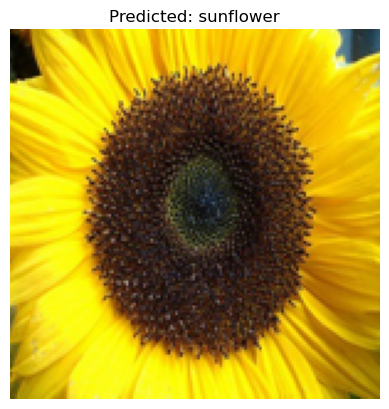


Enter the path of an image to predict (or type 'exit' to quit):  flower_dataset\test\Image_135.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Label: rose


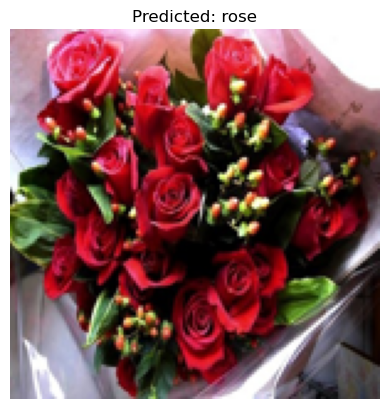


Enter the path of an image to predict (or type 'exit' to quit):  exit


Exiting prediction loop.

Select a task:
1. Flower Species Classification
2. Plant Disease Detection
3. Exit


Enter the task number:  2


Using loaded model for Plant Disease Detection.
Found 9534 images belonging to 15 classes.
Found 2376 images belonging to 15 classes.



Enter the path of an image to predict (or type 'exit' to quit):  PlantVillage/Test/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted Label: Tomato_healthy


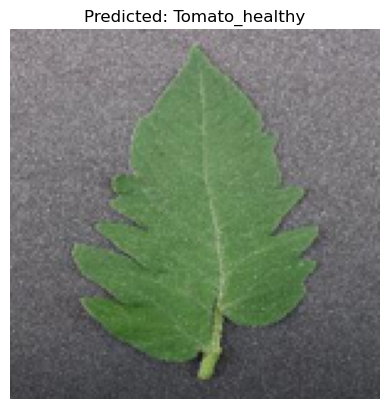


Enter the path of an image to predict (or type 'exit' to quit):  PlantVillage/Test/0b65e4d3-9a6e-463a-b930-814c787d01c6___UF.GRC_YLCV_Lab 01910.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Label: Tomato__Tomato_YellowLeaf__Curl_Virus


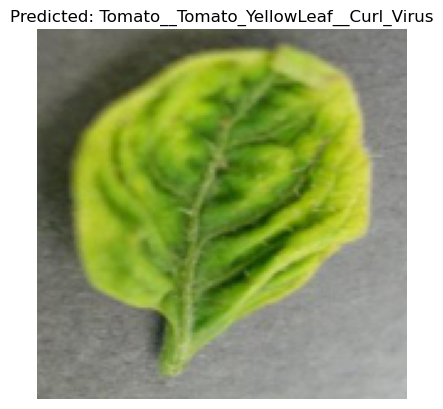

In [ ]:
# Main program
def main():
    while True:
        print("\nSelect a task:")
        for i, key in enumerate(datasets.keys(), 1):
            print(f"{i}. {datasets[key]['task_name']}")
        print("3. Exit")

        task_choice = int(input("Enter the task number: ")) - 1
        if task_choice == 2:
            print("Exiting program.")
            break

        task_key = list(datasets.keys())[task_choice]
        model = get_model(task_key)
        train_generator, _ = load_data(task_key)
        predict_images_in_loop(model, train_generator.class_indices)

if __name__ == "__main__":
    main()